# **Important libraries**

In [1]:
import os
import numpy as np
import seaborn as sns
import librosa
import shutil
from io import BytesIO
from PIL import Image, ImageOps
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.optimizers import Adam

2024-02-20 22:41:20.177871: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-20 22:41:20.178003: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-20 22:41:20.333228: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# **Spectrograms preprocessing**

In [2]:
data_path = '/kaggle/input/new-letters-spectrograms-200x200/letters_spectrograms200 (1)/letters_spectrograms'
data = []
labels = []  
categories = os.listdir(data_path)
for category in categories:
    category_path = os.path.join(data_path, category)
    for img_name in os.listdir(category_path):
        img_path = os.path.join(category_path, img_name)
        img = load_img(img_path, target_size=(100, 100))
        padded_img = ImageOps.expand(img, border=10, fill='white')
        img_array = img_to_array(padded_img)
        img_array /= 255.0
        data.append(img_array)
        labels.append(category)
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)
categorical_labels = to_categorical(encoded_labels)

In [3]:
X_train, X_test, y_train, y_test = train_test_split(data, categorical_labels, test_size=0.1, random_state=42)
X_test,X_val,y_test,y_val=train_test_split(X_test,y_test,test_size=0.5, random_state=42)
X_train = np.array(X_train)
X_val = np.array(X_val)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_val = np.array(y_val)
y_test = np.array(y_test)
print(f'X_train shape is {X_train.shape}')
print(f'X_val shape is {X_val.shape}')
print(f'X_test shape is {X_test.shape}')
print(f'y_train shape is {y_train.shape}')
print(f'y_val shape is {y_val.shape}')
print(f'y_test shape is {y_test.shape}')

X_train shape is (20381, 120, 120, 3)
X_val shape is (1133, 120, 120, 3)
X_test shape is (1132, 120, 120, 3)
y_train shape is (20381, 28)
y_val shape is (1133, 28)
y_test shape is (1132, 28)


# **CNN from scratch**

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import regularizers
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
num_classes = 28
model = Sequential()
model.add(Conv2D(200, (3, 3), activation='relu', input_shape=(120, 120, 3)))
model.add(MaxPooling2D((4, 4)))
model.add(BatchNormalization())
model.add(Conv2D(100, (3, 3),activation='relu'))
model.add(MaxPooling2D((4, 4)))
model.add(BatchNormalization())
model.add(Conv2D(50, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization())
model.add(Flatten())
model.add(Dense(200, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(100, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))
optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])


# Define callbacks
early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)

# Train the model with data augmentation
ThisModel = model.fit(
    X_train, 
    y_train, 
    batch_size=128,
    epochs=100,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping],
    verbose=1
)

# Evaluate the model on test data
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

# Make predictions
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)
# Generate confusion matrix and visualize
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=categories, yticklabels=categories)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()
# Print classification report
print('\nClassification Report:')
print(classification_report(y_true_classes, y_pred_classes, target_names=categories))

In [ ]:
fig = plt.figure(figsize=(10,5))

# Plot accuracy
plt.subplot(221)
plt.plot(ThisModel.history['acc'],'bo--', label = "acc")
plt.plot(ThisModel.history['val_acc'], 'ro--', label = "val_acc")
plt.title("train_acc vs val_acc")
plt.ylabel("accuracy")
plt.xlabel("epochs")
plt.legend()

# Plot loss function
plt.subplot(222)
plt.plot(ThisModel.history['loss'],'bo--', label = "loss")
plt.plot(ThisModel.history['val_loss'], 'ro--', label = "val_loss")
plt.title("train_loss vs val_loss")
plt.ylabel("loss")
plt.xlabel("epochs")

plt.legend()
plt.show()

In [7]:
model_json = model.to_json()
with open("Vgg16_model.json", "w") as json_file:
    json_file.write(model_json)

model.save_weights("Vgg16_model_weights.h5")

In [6]:
import os
import json
from tensorflow.keras.models import model_from_json
with open("/kaggle/input/spectrogram-classifier-by-cnn-from-scratch/model.json", "r") as json_file:
    model = json_file.read()

model = model_from_json(model)
model.load_weights("/kaggle/input/spectrogram-classifier-by-cnn-from-scratch/model_weights.h5")

708/708 [==============================] - 26s 30ms/step - loss: 0.0954 - accuracy: 0.9811
Test Accuracy: 98.11%
708/708 [==============================] - 19s 26ms/step


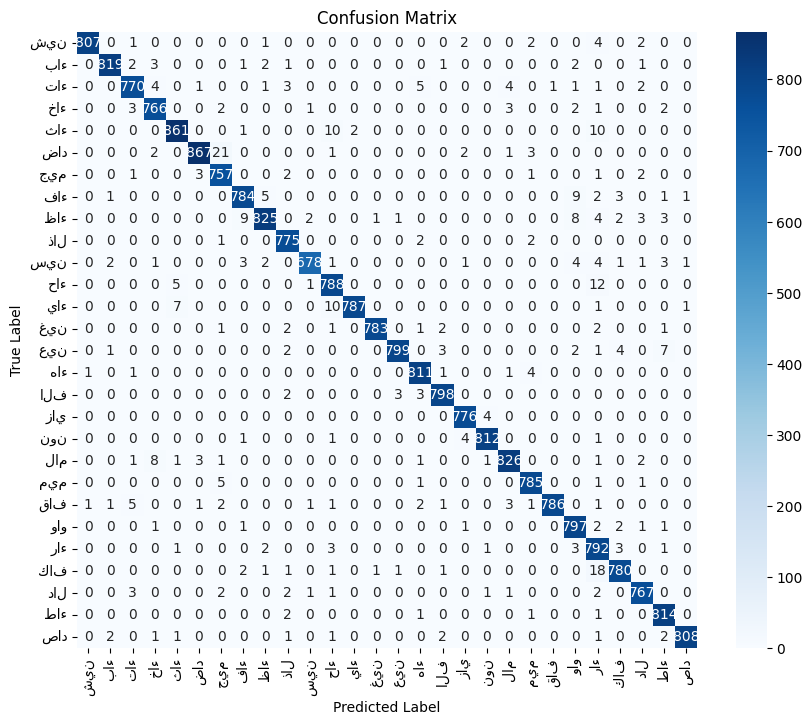


Classification Report:
              precision    recall  f1-score   support

         شين       1.00      0.99      0.99       819
         باء       0.99      0.98      0.99       832
         تاء       0.98      0.97      0.97       793
         خاء       0.97      0.98      0.98       780
         ثاء       0.98      0.97      0.98       884
         ضاد       0.99      0.97      0.98       897
         جيم       0.96      0.99      0.97       767
         فاء       0.98      0.97      0.98       806
         ظاء       0.98      0.96      0.97       858
         ذال       0.98      0.99      0.99       780
         سين       0.99      0.97      0.98       702
         حاء       0.96      0.98      0.97       806
         ياء       1.00      0.98      0.99       806
         غين       1.00      0.99      0.99       793
         عين       0.99      0.98      0.98       819
         هاء       0.98      0.99      0.99       819
         الف       0.99      0.99      0.99       806
   

In [8]:
optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
data_path = '/kaggle/input/test-letters-spectrograms/test_letters_spectrograms/test_letters_data_spectrograms'
data = []   # List to store image data
labels = []  # List to store labels
categories = os.listdir(data_path) # List of categories in this dataset
# Loop over each category
for category in categories:
    category_path = os.path.join(data_path, category) # Full path to the category directory
    # Loop over each image in the category
    for img_name in os.listdir(category_path):
        img_path = os.path.join(category_path, img_name) # Full path to the image file
        img = load_img(img_path, target_size=(100, 100))
        padded_img = ImageOps.expand(img, border=10, fill='white')
        img_array = img_to_array(padded_img) # Convert image to a NumPy array
        img_array /= 255.0  # Normalize pixel values to [0,1]
        data.append(img_array)
        labels.append(category)
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)
categorical_labels = to_categorical(encoded_labels)
X_test=np.array(data)
y_test=np.array(categorical_labels)
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=categories, yticklabels=categories)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()
print('\nClassification Report:')
print(classification_report(y_true_classes, y_pred_classes, target_names=categories))

In [8]:
signal,sr=librosa.load('/kaggle/input/arabic-letters-speech/Alphabet Classification (Multi-Class)/الف/0_0_Taj_Alif_T (27).wav',sr=16000)
trimmed_signal, _ = librosa.effects.trim(signal)
normalized_audio = librosa.util.normalize(trimmed_signal)
duration=int(1*sr)
padded_audio = librosa.util.fix_length(trimmed_signal, size=duration)
mfcc_feature = librosa.feature.mfcc(y=signal, sr=16000, n_fft=1024,hop_length=30,n_mfcc=13)
scaler = StandardScaler()
mfcc_feature_standardized = scaler.fit_transform(mfcc_feature)
plt.figure(figsize=(1, 1))
librosa.display.specshow(librosa.amplitude_to_db(mfcc_feature_standardized,ref=np.max))
plt.colorbar(format='%+2.0f dB').remove()
buf = BytesIO()
plt.savefig(buf, format='png', bbox_inches='tight', pad_inches=0, transparent=True, dpi=100)
buf.seek(0)
image_name = "test_spectrogram.png"
image_path = "/kaggle/working/"+image_name
img = Image.open(buf)
img = img.resize((200, 200), Image.LANCZOS)
img.save(image_path, format='png')
plt.close()
buf.close() 
img_list=[]
img = load_img('/kaggle/working/test_spectrogram.png', target_size=(100, 100))
padded_img = ImageOps.expand(img, border=10, fill='white')
img_array = img_to_array(padded_img)
img_array /= 255.0
img_list.append(img_array)
prediction=model.predict(np.array(img_list))
print(np.argmax(prediction, axis=1))

1/1 [==============================] - 1s 867ms/step
[19]


# **Divide Data to K folds**

In [ ]:
import numpy as np
from sklearn.model_selection import StratifiedShuffleSplit
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
# Define the number of folds
k_folds = 3
input_shape=(120, 120, 3)
num_classes=28
# Initialize StratifiedShuffleSplit
sss = StratifiedShuffleSplit(n_splits=k_folds, test_size=0.2, random_state=42)

# Lists to store evaluation metrics
test_accuracies = []
conf_matrices = []
base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
X=np.array(data)
y=np.array(categorical_labels)
# Loop through each fold
for fold, (train_index, test_index) in enumerate(sss.split(X, y)):
    print(f'Fold {fold + 1}/{k_folds}')
    
    # Split data into train and test sets for this fold
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    # Define and compile the model
    model = Sequential([
        base_model,
        Flatten(),
        Dense(512, activation='relu'),
        Dense(256, activation='relu'),
        Dense(128, activation='relu'),
        Dense(64, activation='relu'),
        Dense(32, activation='relu'),
        Dense(num_classes, activation='softmax')  
    ])
    optimizer = Adam(learning_rate=0.0001)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)
    # Train the model
    history = model.fit(
        X_train,
        y_train,
        batch_size=128,
        epochs=100,
        validation_data=(X_test, y_test),
        callbacks=[early_stopping],
        verbose=1
    )
    
    # Evaluate the model on test data
    test_loss, test_accuracy = model.evaluate(X_test, y_test)
    test_accuracies.append(test_accuracy)
    
    # Make predictions
    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true_classes = np.argmax(y_test, axis=1)
    
    # Generate confusion matrix and store
    conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)
    conf_matrices.append(conf_matrix)

# Print average test accuracy across all folds
print(f'Average Test Accuracy: {np.mean(test_accuracies) * 100:.2f}%')

# Print average confusion matrix across all folds
avg_conf_matrix = np.mean(conf_matrices, axis=0)
plt.figure(figsize=(10, 8))
sns.heatmap(avg_conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=categories, yticklabels=categories)
plt.title('Average Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


Fold 1/5
Epoch 1/100


I0000 00:00:1708461968.839906    1493 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


142/142 [==============================] - 125s 650ms/step - loss: 3.3331 - accuracy: 0.0360 - val_loss: 3.3317 - val_accuracy: 0.0364
Epoch 2/100
142/142 [==============================] - 72s 508ms/step - loss: 3.2953 - accuracy: 0.0538 - val_loss: 3.1886 - val_accuracy: 0.0872
Epoch 3/100
142/142 [==============================] - 72s 510ms/step - loss: 2.7849 - accuracy: 0.1857 - val_loss: 2.4097 - val_accuracy: 0.2854
Epoch 4/100
142/142 [==============================] - 73s 511ms/step - loss: 2.0421 - accuracy: 0.3896 - val_loss: 1.7322 - val_accuracy: 0.4832
Epoch 5/100
142/142 [==============================] - 73s 512ms/step - loss: 1.4558 - accuracy: 0.5528 - val_loss: 1.3559 - val_accuracy: 0.5852
Epoch 6/100
142/142 [==============================] - 73s 512ms/step - loss: 1.0179 - accuracy: 0.6792 - val_loss: 1.0074 - val_accuracy: 0.6905
Epoch 7/100
142/142 [==============================] - 73s 513ms/step - loss: 0.7074 - accuracy: 0.7779 - val_loss: 0.7901 - val_accura